In [38]:
from sklearn.datasets import fetch_lfw_pairs
import torch
# from torch.utils.data import Dataset
from torchvision import transforms , datasets
from Dataset import LFWtripletDataset
import matplotlib.pyplot as plt
import TriNetSiamese 
from TriNetSiamese import TriNetSiamese
from torchinfo import summary
import helper
import train


In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
helper.set_random_seed()

Random seed set to: 13


Total People: 5758
Total Images: 13233
Max Images for a Person: 530
Total People with one Image: 4069
Total People with multiple Images: 1680


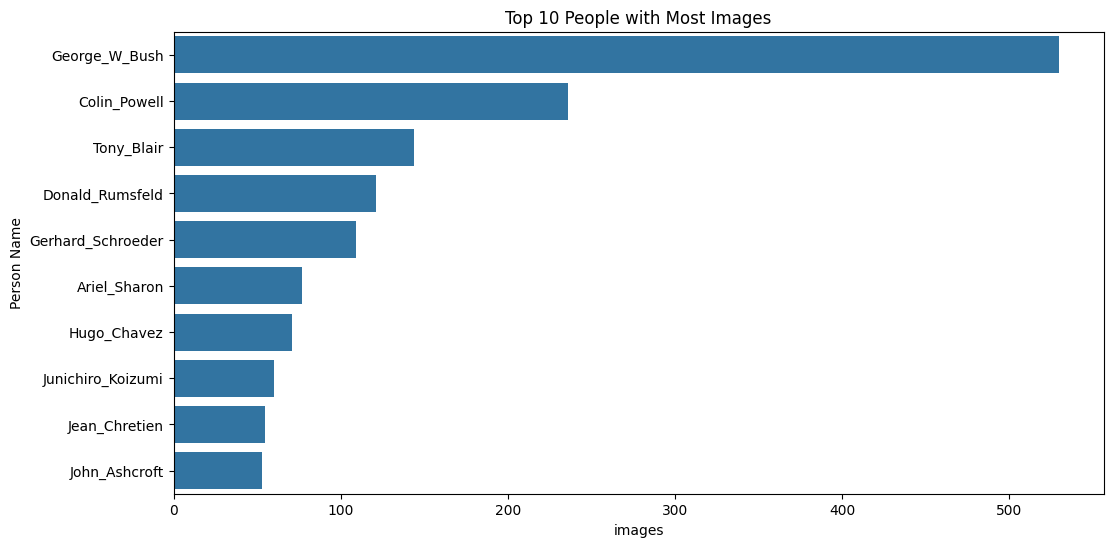

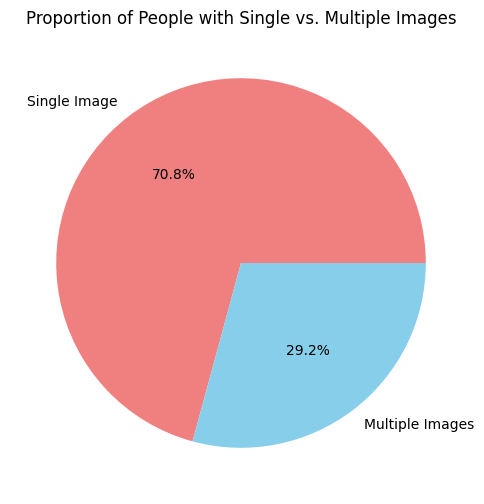

In [41]:
root_dir = "data/lfw-py"

dataset = LFWtripletDataset(root_dir=root_dir, transform=None)
dataset.statistics()


### Triplet Sampling Strategy

Since **70% of the dataset** consists of individuals with only a single image, these individuals cannot be used for anchor-positive pairing.  

To construct triplets:  
- For the **1,680 individuals** who have multiple images, each image can serve as an **anchor**.  
- A **positive sample** is randomly selected from another image of the same person.  
- A **negative sample** is randomly chosen from the **4,069 individuals** who have only one image, ensuring that the negative comes from a different identity.  

This approach in our opinion will maximize the use of available data while maintaining a meaningful triplet structure for training.



In [42]:
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()   
])
train_dataset = LFWtripletDataset(root_dir=root_dir, split="train", transform=transforms)
print(train_dataset.__len__())
test_dataset = LFWtripletDataset(root_dir=root_dir, split="test", transform=transforms)
print(test_dataset.__len__())

6671
2493


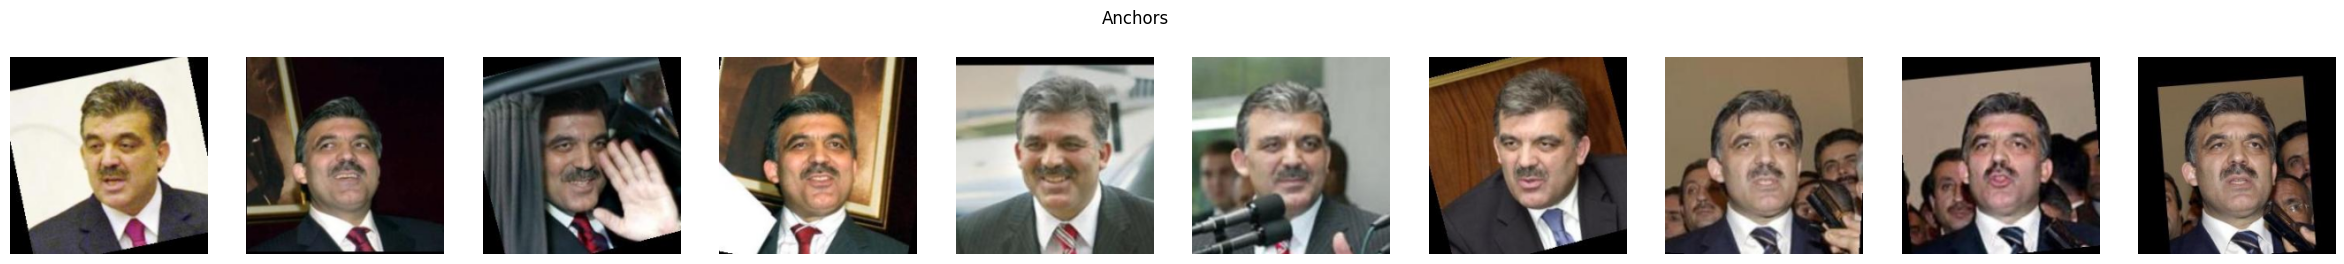

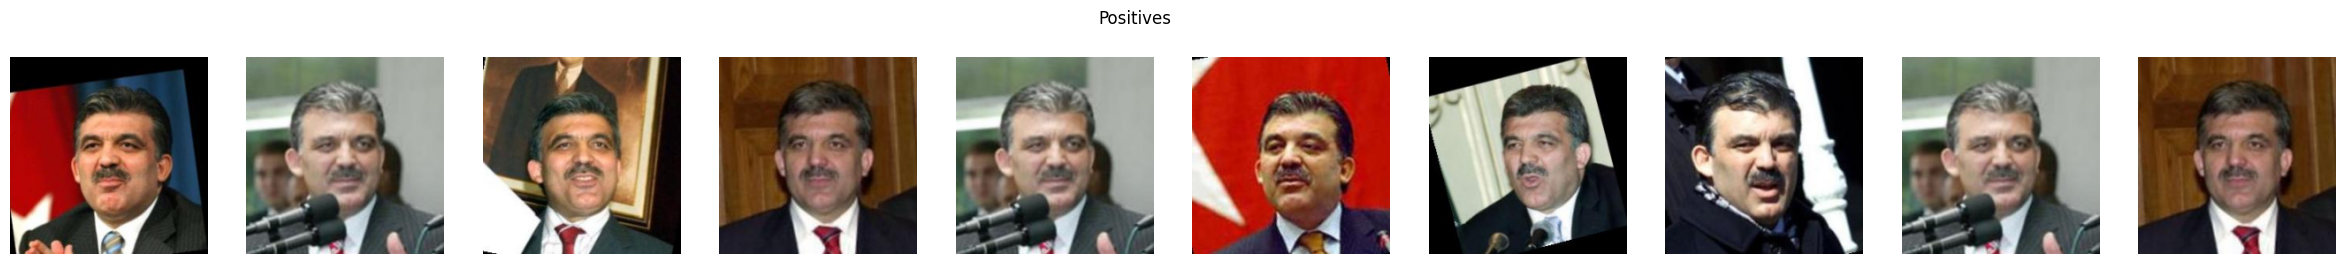

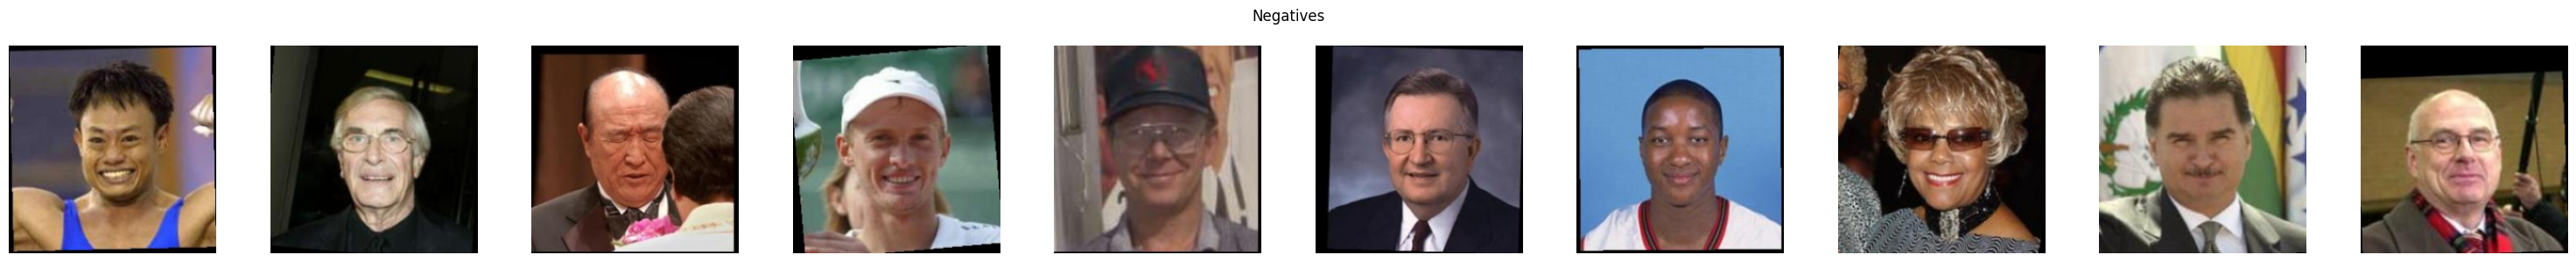

In [43]:
fig_anchors, anchors = plt.subplots(1, 10, figsize=(30, 3))
fig_pos, positives = plt.subplots(1, 10, figsize=(30, 3))
fig_neg, negatives = plt.subplots(1, 10, figsize=(30, 3))

for i in range(10):
    # Get the anchor, positive, and negative images from the dataset
    (anchor, positive, negative), _ = test_dataset[i]
    
    # Convert from (C, H, W) to (H, W, C) 
    anchor = anchor.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
    positive = positive.permute(1, 2, 0).numpy()
    negative = negative.permute(1, 2, 0).numpy()
    
    # Display the images
    anchors[i].imshow(anchor)
    anchors[i].axis("off")
    
    positives[i].imshow(positive)
    positives[i].axis("off")
    
    negatives[i].imshow(negative)
    negatives[i].axis("off")

# Set titles
fig_anchors.suptitle("Anchors")
fig_pos.suptitle("Positives")
fig_neg.suptitle("Negatives")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [44]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False) 

In [45]:
model = TriNetSiamese()
model

/home/user/elwakeely1/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/elwakeely1/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TriNetSiamese(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [46]:
criterion = train.TripletLoss(margin=0.2)
trainer = train.Trainer(model=model, criterion=criterion, train_loader=train_loader, test_loader=test_loader, n_iters=1000)

In [ ]:
trainer.fit()

Valid loss @ iteration 0: Loss=0.10024787762608284
